In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize
from tensorflow.keras.utils import plot_model
from tensorflow.train import Checkpoint
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Input, concatenate,ZeroPadding2D,Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU,Conv2D 
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.summary import scalar
import pathlib
import time
import datetime
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from IPython import display
import pandas as pd

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"cosmos23","key":"9c9674576edaad75dbd8dad6f566d58b"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c photo-reconstruction
!unzip photo-reconstruction.zip

In [3]:
!pwd
!ls

/kaggle/working
Dataset			   photo-reconstruction.zip
__notebook_source__.ipynb  sample_submission.csv


In [4]:
import os
#setting the directory paths for different classes
dir_path            = "Dataset"
test_path           = "Dataset/Testing_Data"
train_cat_path      = "Dataset/Training_Data/Cat"
train_dog_path      = "Dataset/Training_Data/Dog"
train_elephant_path = "Dataset/Training_Data/Elephant"
train_tiger_path    = "Dataset/Training_Data/Tiger"
test_list           = os.listdir(test_path)
train_cat_list      = os.listdir(train_cat_path+"/Unmasked_Train")
train_dog_list      = os.listdir(train_dog_path+"/Unmasked_Train")
train_elephant_list = os.listdir(train_elephant_path+"/Unmasked_Train")
train_tiger_list    = os.listdir(train_tiger_path+"/Unmasked_Train")
Masked_info         = 'photo-reconstruction-train-zip/All_together/Masked_Train'
Unmasked_info       = 'photo-reconstruction-train-zip/All_together/Unmasked_Train'
cat_masked_info     = "photo-reconstruction/Dataset/Training_Data/Cat/Masked_Train/masked_info.csv"
dog_masked_info     = "photo-reconstruction/Dataset/Training_Data/Dog/Masked_Train/masked_info.csv"
elephant_masked_info= "photo-reconstruction/Dataset/Training_Data/Elephant/Masked_Train/masked_info.csv"
tiger_masked_info   = "photo-reconstruction/Dataset/Training_Data/Tiger/Masked_Train/masked_info.csv"

In [5]:
train_size          = int(len(train_cat_list)*0.8)
batch_size          = 10   
lambda_for_loss     = 100
img_width           = 256
img_height          = 256
output_channels     = 3

In [6]:
#defining helper fucntions for data pre-processing
def normalize(masked, real):
    masked = (masked / 127.5) - 1
    real = (real / 127.5) - 1
    return masked, real
def resize(input_image, real_image, height, width):
    input_image = resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image
def load(masked_image, real_image):
    masked_image = tf.io.read_file(tuple_image[0])
    masked_image = tf.io.decode_jpeg(masked_image)
    masked_image = tf.cast(masked_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)  
    return masked_image, real_image
def load_image_train(masked_image, real_image):
    masked_image, real_image = normalize(masked_image, real_image)
    return masked_image, real_image
def load_image_test(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, [img_height, img_width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image
def load_image_val(image):
    masked_image, real_image = load(image)
    masked_image, real_image = normalize(masked_image, real_image)
    return masked_image, real_image
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, img_height, img_width, 3])
    return cropped_image[0], cropped_image[1]

In [7]:
@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image  = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [8]:
cat_masked_data = keras.utils.image_dataset_from_directory(directory="Dataset/Training_Data/Cat/Masked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
cat_unmasked_data = keras.utils.image_dataset_from_directory(directory="Dataset/Training_Data/Cat/Unmasked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
dog_masked_data = keras.utils.image_dataset_from_directory(directory="Dataset/Training_Data/Dog/Masked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
dog_unmasked_data = keras.utils.image_dataset_from_directory(directory="Dataset/Training_Data/Dog/Unmasked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
elephant_masked_data = keras.utils.image_dataset_from_directory(directory="Dataset/Training_Data/Elephant/Masked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
elephant_unmasked_data = keras.utils.image_dataset_from_directory(directory="Dataset/Training_Data/Elephant/Unmasked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
tiger_masked_data = keras.utils.image_dataset_from_directory(directory="Dataset/Training_Data/Tiger/Masked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
tiger_unmasked_data = keras.utils.image_dataset_from_directory(directory="Dataset/Training_Data/Tiger/Unmasked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
masked_data = cat_masked_data.concatenate(dog_masked_data.concatenate(elephant_masked_data.concatenate(tiger_masked_data)))
unmasked_data = cat_unmasked_data.concatenate(dog_unmasked_data.concatenate(elephant_unmasked_data.concatenate(tiger_unmasked_data)))
test_dataset = keras.utils.image_dataset_from_directory(directory="Dataset/Testing_Data", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)

Found 1750 files belonging to 1 classes.
Found 1750 files belonging to 1 classes.
Found 1750 files belonging to 1 classes.
Found 1750 files belonging to 1 classes.
Found 1750 files belonging to 1 classes.
Found 1750 files belonging to 1 classes.
Found 1750 files belonging to 1 classes.
Found 1750 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


In [9]:
dataset = tf.data.Dataset.zip((masked_data, unmasked_data))
train_size = int(0.8*dataset.cardinality().numpy())
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices([os.path.join(test_path, filename) for filename in test_list])
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(batch_size)

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.03)
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [12]:
def Generator():
    inputs = Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(output_channels, 4,
                            strides=2,
                            padding='same',
                            kernel_initializer=initializer,
                            activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

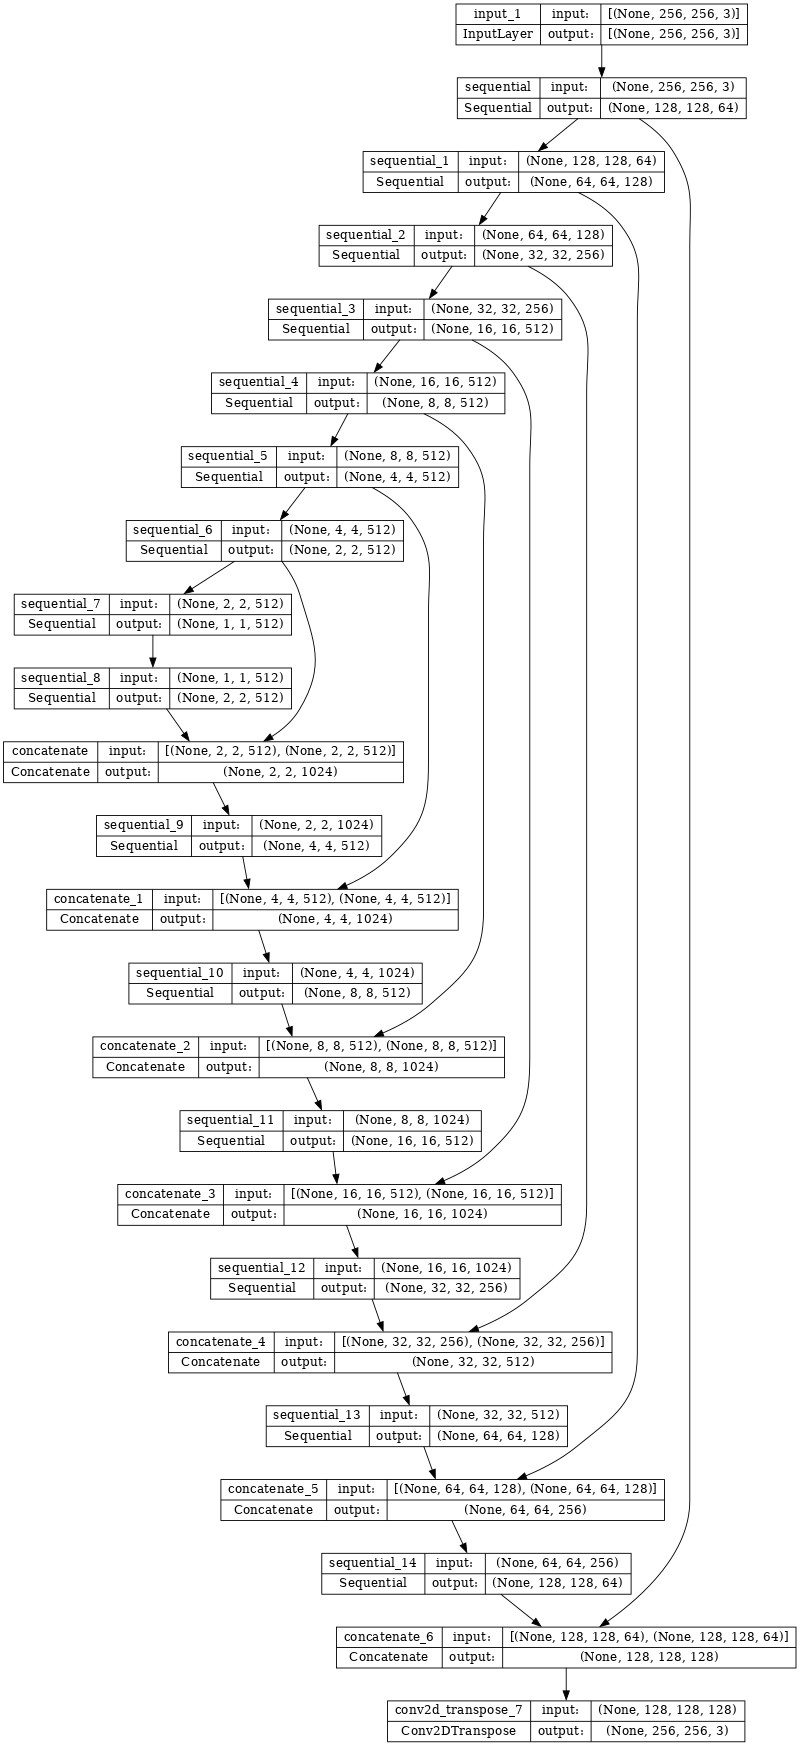

In [13]:
generator = Generator()
plot_model(generator, show_shapes=True, dpi=64)

In [14]:
# inp = tf.io.read_file(str("Dataset/Training_Data/Cat/Masked_Train/Cat-Train (1122).jpeg"))
# inp = tf.io.decode_jpeg(inp)
# inp = tf.cast(inp, tf.float32)
# plt.figure()
# plt.imshow(inp / 255.0)
# plt.figure()

In [15]:
# gen_output = generator(inp[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])

In [16]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (lambda_for_loss * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=[256, 256, 3], name='input_image')
    tar = Input(shape=[256, 256, 3], name='target_image')
    x = concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
    zero_pad1 = ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1,
                  kernel_initializer=initializer,
                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    last = Conv2D(1, 4, strides=1,
                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    return Model(inputs=[inp, tar], outputs=last)

In [19]:
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [20]:
# disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
# plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

In [21]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = Checkpoint(generator_optimizer=generator_optimizer,
                        discriminator_optimizer=discriminator_optimizer,
                        generator=generator,
                        discriminator=discriminator)

In [24]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [26]:
log_dir="./logs/"
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [27]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    with summary_writer.as_default():
        scalar('gen_total_loss', gen_total_loss, step=step//1000)
        scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        scalar('disc_loss', disc_loss, step=step//1000)

In [28]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            start = time.time()
            generate_images(generator, example_input, example_target)
        train_step(input_image, target, step)
        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

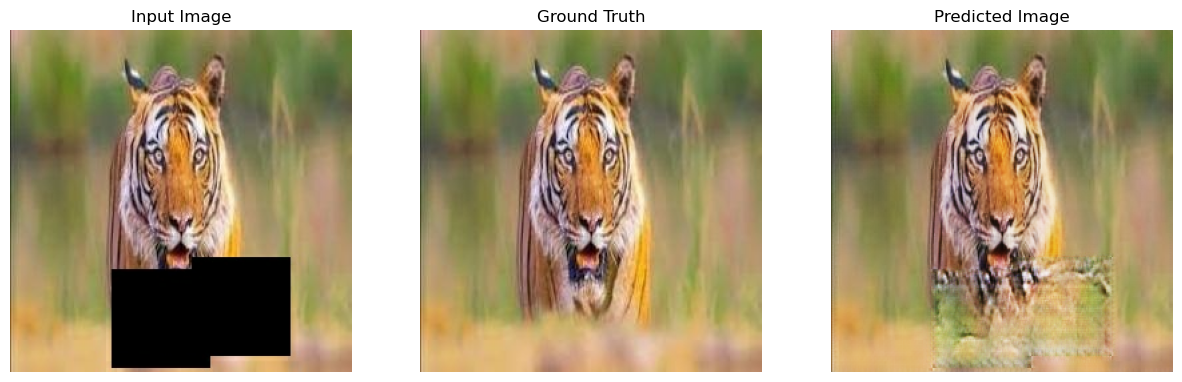

....................................................................................................

In [29]:
fit(train_dataset, val_dataset, steps=40000)

In [ ]:
#generator.save('./')

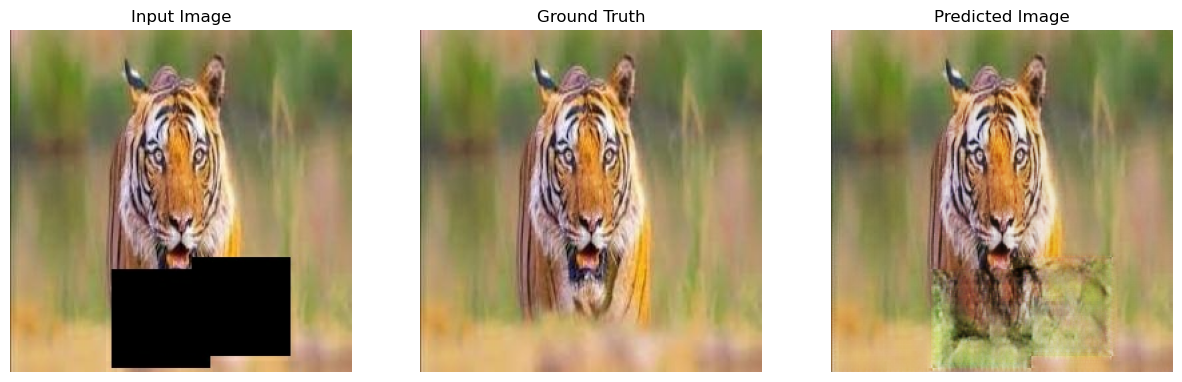

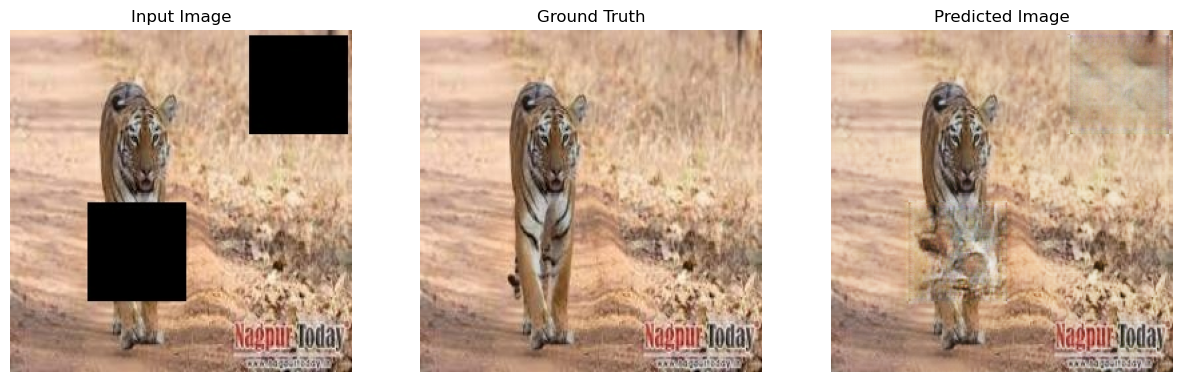

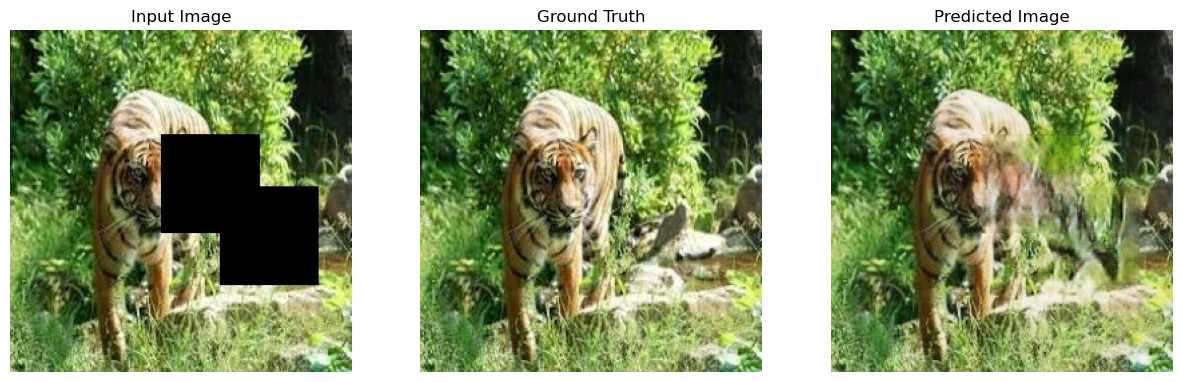

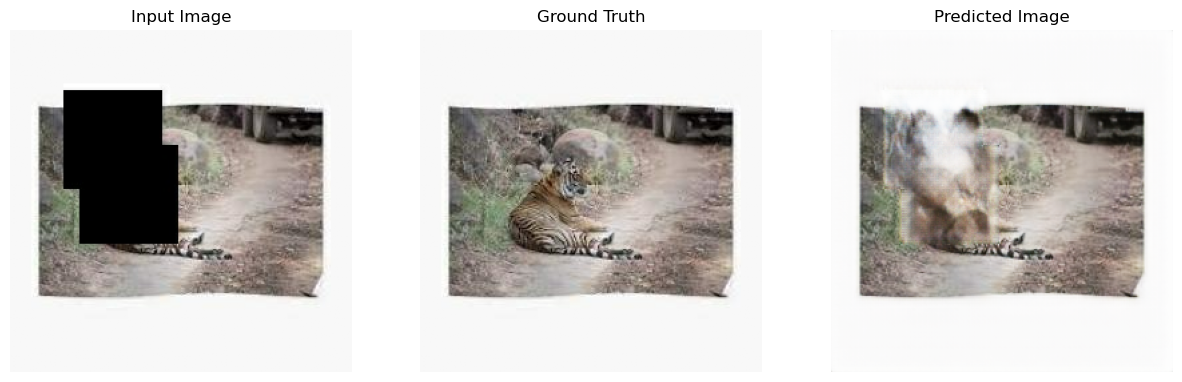

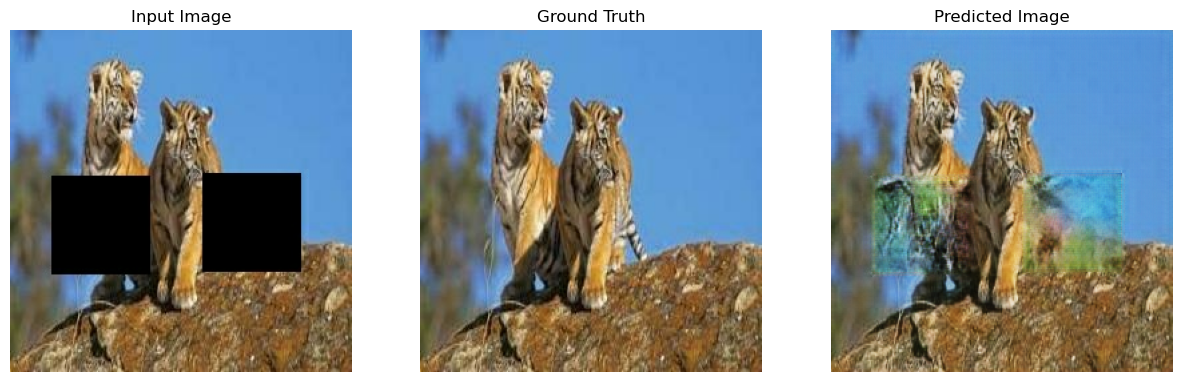

In [30]:
for inp, tar in val_dataset.take(5):
    generate_images(generator, inp, tar)

In [31]:
def generate_images_test(model, test_input, plot=False):
    prediction = model(test_input, training=True)
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image',  'Predicted Image']
    if plot==True:
        plt.figure(figsize=(15, 15))
        for i in range(2):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()
    return prediction[0]

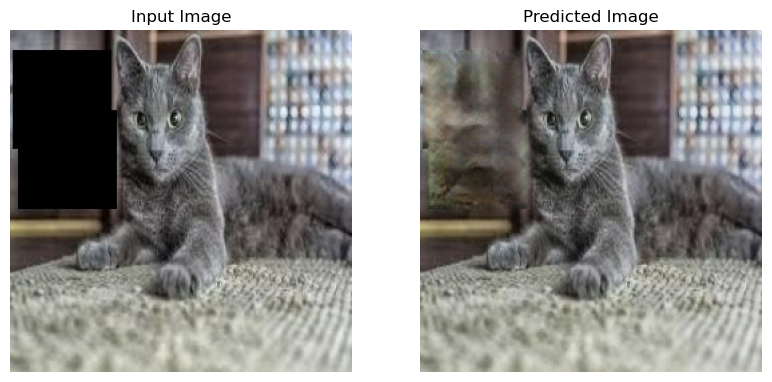

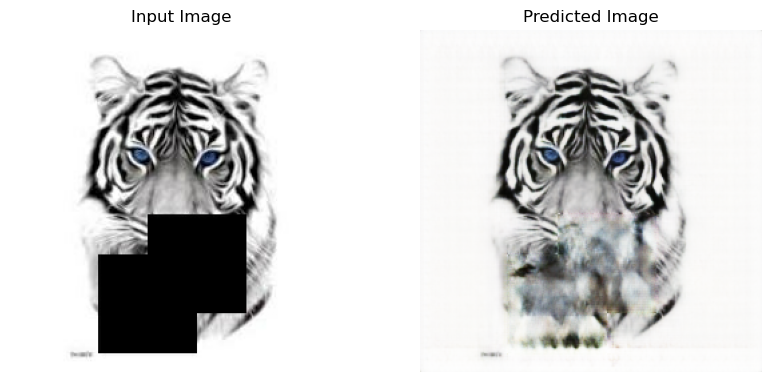

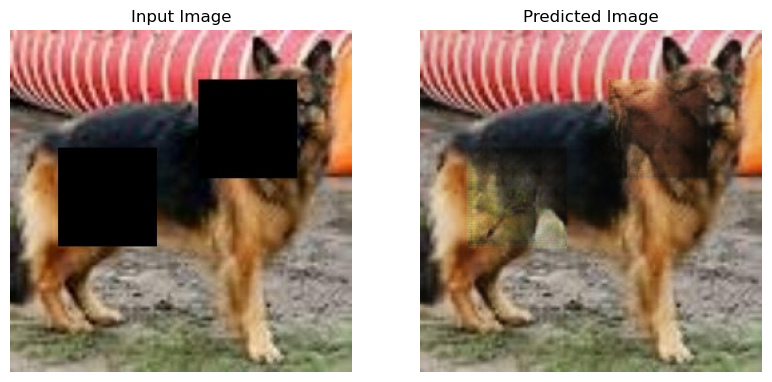

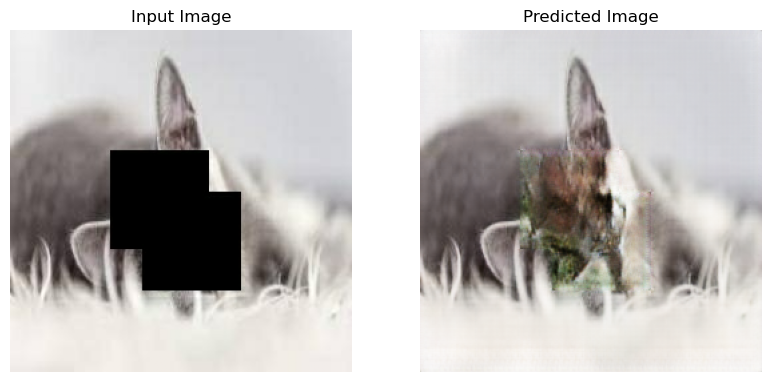

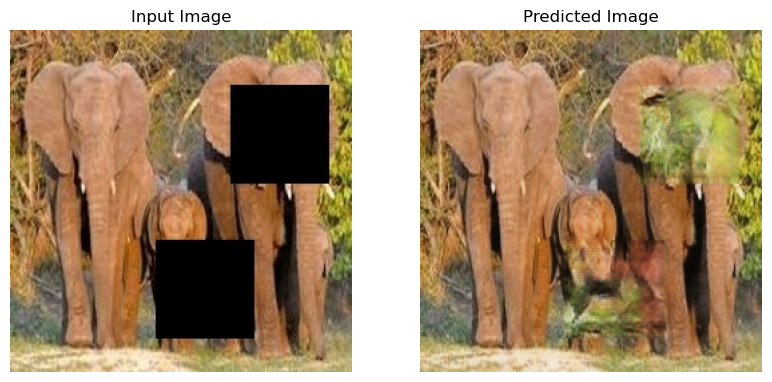

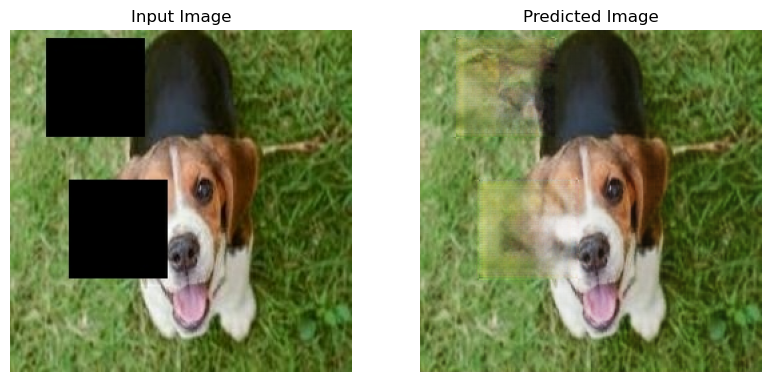

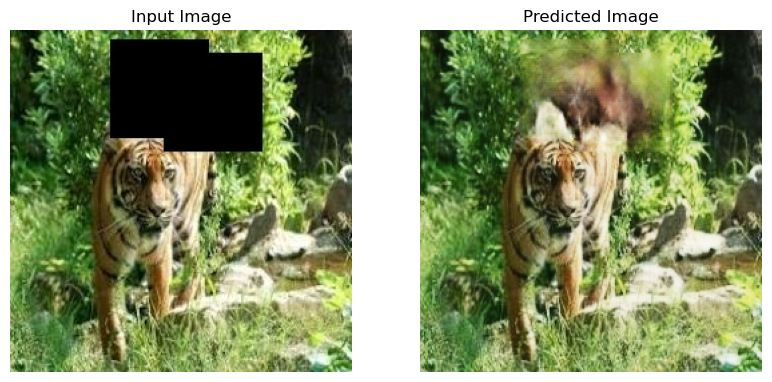

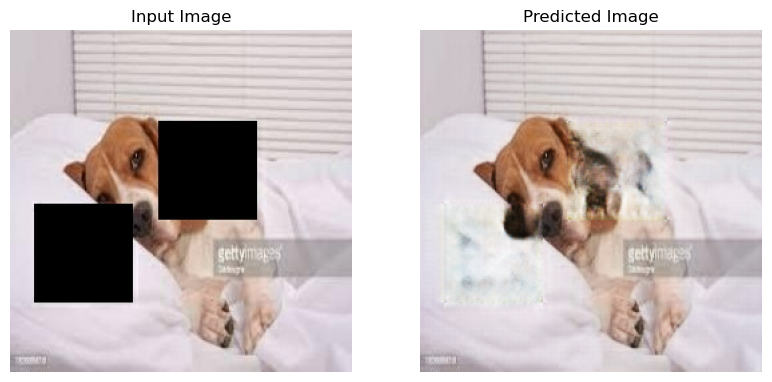

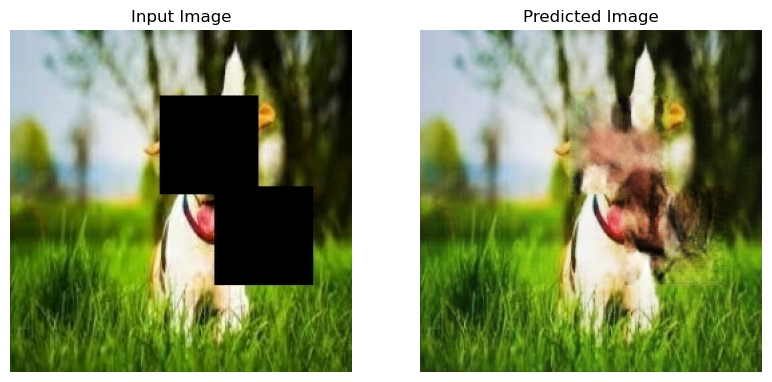

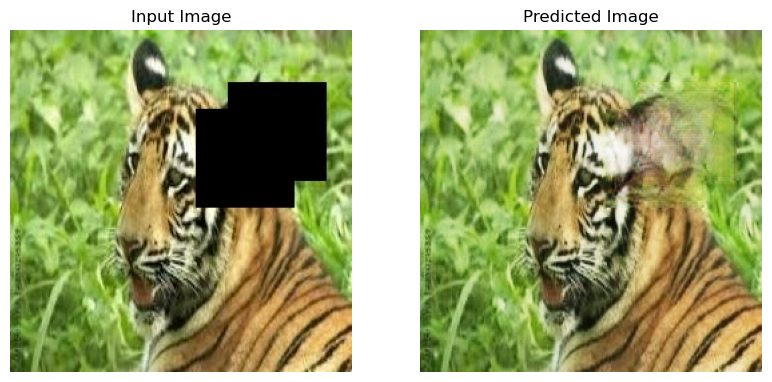

In [32]:
for inp in test_dataset.take(10):
    generate_images_test(generator, inp, plot=True)

In [33]:
def submission_data(test_path):
    test_mask_data = pd.read_csv(os.path.join(test_path, 'masked_info.csv')).drop(['Unnamed: 0'],axis=1)
    submission = []
    for i in range(len(test_mask_data)):
        filename, y1, x1, y2, x2 = test_mask_data.loc[i,]
        inp =   tf.data.Dataset.from_tensor_slices([os.path.join(test_path,  filename)])
        inp =   inp.map(load_image_test)
        inp = inp.batch(batch_size)
        for img in inp.take(1):
            image=generate_images_test(generator, img)
        im = np.array(image)
        b, g, r = cv.split(im)
        result = np.zeros((256, 256))
        normalized_b = cv.normalize(b,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        normalized_g = cv.normalize(g,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        normalized_r = cv.normalize(r,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        for i in range(y1 , y1+75):
            for j in range(x1, x1+75):
                temp1 = filename + '_' + 'box1' + '_' +  str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', normalized_b[i,j]))
                submission.append((temp1 + '1', normalized_g[i,j]))
                submission.append((temp1 + '2', normalized_r[i,j]))
        for i in range(y2 , y2+75):
            for j in range(x2, x2+75):
                temp1 = filename + '_' + 'box2' + '_' + str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', normalized_b[i,j]))
                submission.append((temp1 + '1', normalized_g[i,j]))
                submission.append((temp1 + '2', normalized_r[i,j]))
        df = pd.DataFrame(submission, columns=['filename_box_pixel','value'])
    return(df)

df  =   submission_data(test_path)

In [34]:
df.to_csv("submission_32.csv", index=False)